<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/RDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radial distribution function

Maria Kolonsky 2025

v.0.1.1

In [228]:
#! pip install shapely
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from shapely.geometry import Point, box, Polygon
from shapely.prepared import prep
from shapely.strtree import STRtree


## Parse XML datafile for $(x, y)$ points

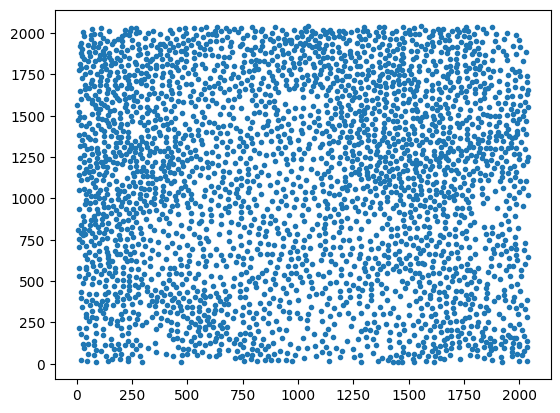

In [350]:
url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/HaCaT%40pla-gel-CPNW%40PMMA(11x11%2Cx20)_2022-05-30_CellCounter_tile_x001_y002%20(1).xml'

#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)


#запуск
resp = urlopen(url, timeout=30)
X, Y = parsing_xml(resp, marker_type=1)

W = int(X.max()) + 1
H = int(Y.max()) + 1

# total square
S = W * H

N =  X.size

points = [Point(float(x), float(y)) for x, y in zip(X, Y)
          if np.isfinite(x) and np.isfinite(y)]
tree = STRtree(points)


plt.scatter(X, Y, marker='.')

## Using module `shapely` to calculate square of intersection of a ring and rectangle

In [496]:
# frame for all x, y points
FRAME = Polygon([(0,0), (W,0), (W,H), (0,H)])


def ring_rect_intersection_area(cx, cy, r, deltar, resolution=8):
    """
    cx, cy:  центр круга
    r:       радиус круга
    deltar: приращение радиуса круга
    resolution: number of segments for quarter of circle
    """
    def circle_rect_intersection_area(cx, cy, r, resolution):
      if (cx + r <= W) & (cx - r >= 0) & (cy + r <= H) & (cy - r >= 0):
        area = np.pi * r**2
      else:
        circle = Point(cx, cy).buffer(r, resolution=resolution) # resolution ↑ => точнее аппроксимация
        area =   FRAME.intersection(circle).area
      return area


    s0 = circle_rect_intersection_area(cx, cy, r, resolution)
    s1 = circle_rect_intersection_area(cx, cy, r + deltar, resolution)
    return s1 - s0

# пример
%time ring_rect_intersection_area(cx=1000, cy=1000, r=20, deltar=2, resolution=8)


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs


263.89378290154264

## Using module `numpy` to calculate number of points inside the ring

In [360]:
def count_points(cx, cy, r, deltar):
  distance2 = (X - cx)*(X - cx) + (Y - cy)*(Y - cy)
  r2 = r*r
  rdr2 = (r + deltar) * (r + deltar)
  mask = (distance2 >= r2) & (distance2 <= rdr2)
  count = np.count_nonzero(mask)
  return count

# пример
%timeit count_points(1000, 1000, 100, 30)


18.4 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Using module `shapely` to calculate number of points inside the ring

In [354]:
'''
def count_points(cx, cy, r, deltar):
  circle = Point(cx, cy).buffer(r, resolution=16)
  candidates = [points[i] for i in tree.query(circle)]
  pc = prep(circle)                                # ускоряет множественные проверки
  count = sum(pc.covers(c) for c in candidates)
  return count

# пример
%timeit count_points(cx=1000, cy=1000, r=100, deltar=30)
'''

'\ndef count_points(cx, cy, r, deltar):\n  circle = Point(cx, cy).buffer(r, resolution=16)\n  candidates = [points[i] for i in tree.query(circle)]\n  pc = prep(circle)                                # ускоряет множественные проверки\n  count = sum(pc.covers(c) for c in candidates)\n  return count\n\n# пример\n%timeit count_points(cx=1000, cy=1000, r=100, deltar=30)\n'

## Find density as number of points to square of intersection

In [416]:
def density(cx, cy, r, deltar):
  count  = count_points(cx, cy, r, deltar)
  relative_count = count / N
  square = ring_rect_intersection_area(cx, cy, r, deltar)
  relative_square = square / S
  if square == 0:
    rho = 0
  else:
    rho = count / N  * S / square
  return rho

#density = np.vectorize(density)

# пример
%timeit density(cx=1000, cy=1000, r=100, deltar=30)

25.6 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Sweep for all possible radius averaged density




CPU times: user 54.6 s, sys: 34.8 ms, total: 54.6 s
Wall time: 55.2 s


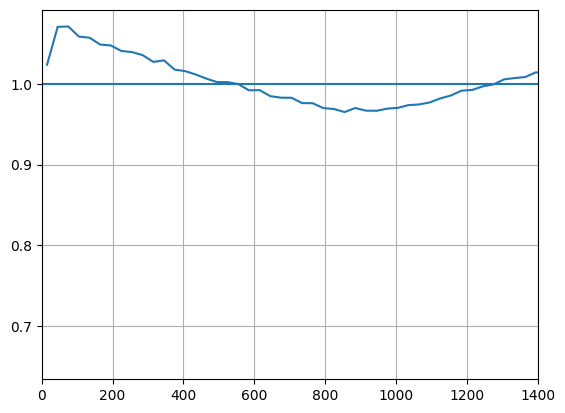

In [497]:
deltar = 30
r_max = min(W, H)

r_edges = np.arange(0, r_max+deltar, deltar, dtype=float)
R = 0.5 * (r_edges[:-1] + r_edges[1:])


#g = np.zeros(R.size)
#for i in range(N):
#  x, y = X[i], Y[i]
#  g += density(x, y, R, deltar )
# g /= N

%time g = [np.mean([density(X[i], Y[i], r, deltar) for i in range(N)]) for r in R]


plt.plot(R, g)
plt.axhline(1)
plt.xlim(0, 1400)
plt.grid()

### The same for uniform distribution

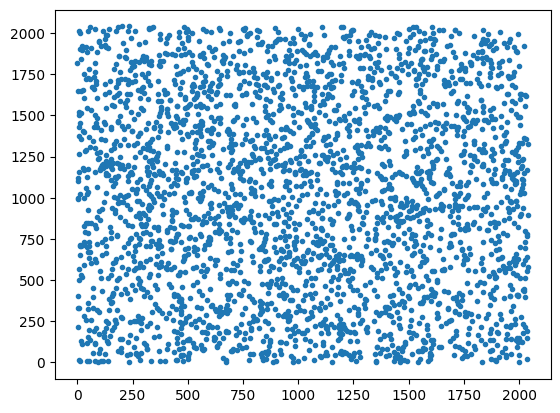

In [498]:
rng = np.random.default_rng(seed=123)
Xu = rng.uniform(0, W, size=N)
Yu = rng.uniform(0, H, size=N)
plt.scatter(Xu, Yu, marker='.')

In [499]:
%time gu = [np.mean([density(Xu[i], Yu[i], r, deltar) for i in range(N)]) for r in R]


CPU times: user 54.5 s, sys: 31 ms, total: 54.5 s
Wall time: 54.7 s


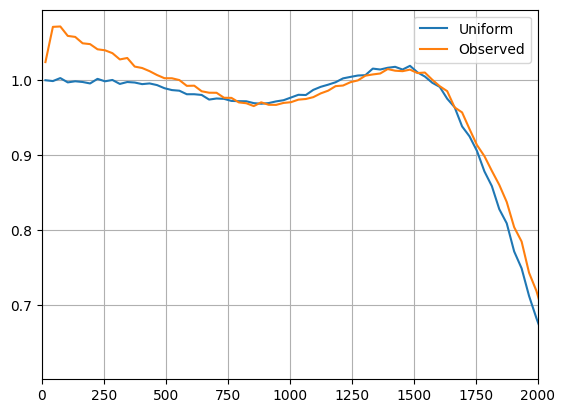

In [500]:
plt.plot(R, gu, label='Uniform')
plt.plot(R, g, label='Observed')
plt.legend()
plt.xlim(0, 2000)
plt.grid()

## test for a point in the center with growing radius

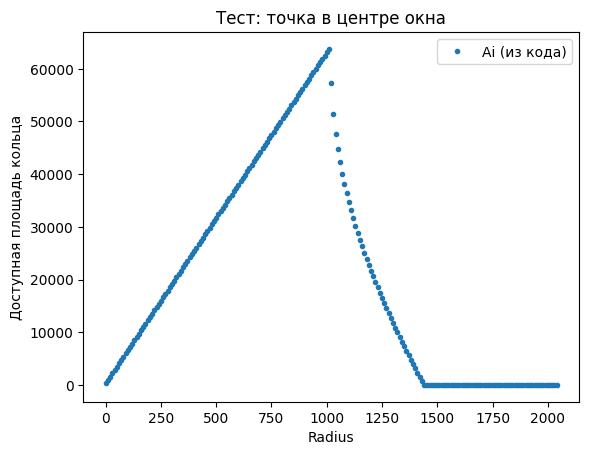

In [501]:
deltar = 10
R = np.arange(0, W, deltar)

xc, yc = W /2, H / 2

Ai = [ring_rect_intersection_area(xc, yc, r, deltar, 64) for r in R]


# график
plt.plot(R, Ai, '.', lw=2, label="Ai (из кода)")
#plt.plot(R, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("Radius")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()